<a href="https://colab.research.google.com/github/POJSpace/Deep_learning_pytorch/blob/main/resources/02_Model2_POJSpace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second NN Model - non-linear



In [1]:
import torch
import sklearn
from torch import nn
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu" # set a device

def plt_predictions(train_data,
                     train_labels,
                     test_data ,
                     test_labels,
                     predictions = None):
  """
  Plots training data, test data amd compares predictions.
  """
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c = "b", s = 4, label = "Training data")

  plt.scatter(test_data, test_labels, c = "g", s = 4, label = "Testing data")


  if predictions is not None:
    plt.scatter(test_data,predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 10})

## Dataset

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

# Funkce make_circles vytvoří dataset s souřadnicema tvarovanými do kruhu, n_samples = počet souřadnic, noise = rozpětí
c, l = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)
print(c.shape, c[:10, :], l[:10]) # c = souřadnice, l = label, c[:,0] = x souřadnice, c[:,1] = y souřadnice

(1000, 2) [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]] [1 1 1 1 0 1 1 1 1 0]


In [3]:
# Vytvoří data frame z datasetu
import pandas as pd

circles = pd.DataFrame({"X": c[:,0],
                        "Y": c[:,1],
                        "label": l})
circles.head(100) # Vypíše nám prvních 100 řádků

,X,Y,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
95,0.705162,-0.791401,0
96,-0.798092,-0.134062,1
97,0.405352,0.911272,0
98,0.656930,0.687583,0


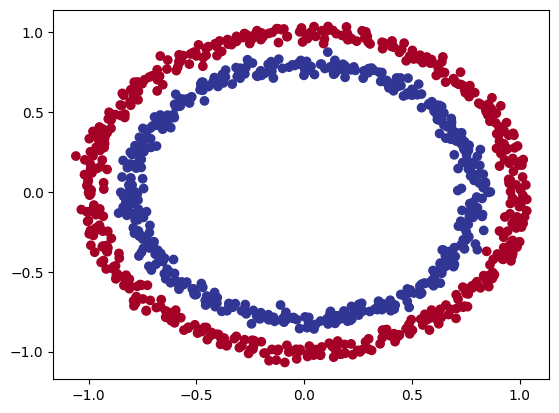

In [4]:
# plt.scatter zobrazí body x a y a přiřadí  nim label (0 / 1)
plt.scatter(x=c[:, 0],
            y=c[:, 1],
            c = l,
            cmap = plt.cm.RdYlBu);

In [5]:
c = torch.from_numpy(c).type(torch.float) # převedeme do numpy at s tím může pracovat skleanr
l = torch.from_numpy(l).type(torch.float)

In [6]:
from sklearn.model_selection import train_test_split

# vytvoříme dataset a splitneme ho na 80% a 20%
x_train, x_test, y_train, y_test = train_test_split(c,
                                                    l,
                                                    test_size = 0.2, #0.2 = 20% wil be test and 80% trained
                                                    random_state = 42)

In [7]:
len(x_train), len(x_test),

(800, 200)

# Model

In [8]:
# Vytvoříme náš model, použijeme nn.Sequential a layers
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)

    )

  def forward(self, c):
    return self.layers(c)

model_0 = CircleModel().to(device) # připojíme přes instanci a určíme device
model_0

CircleModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [9]:
device

'cuda'

In [10]:
# vyzkoušíme predikci
with torch.inference_mode():
  y_preds = model_0(x_test.to(device))
y_preds[1]

tensor([0.7286], device='cuda:0')

In [11]:
# vytvoříme loss function
loss_fn = nn.BCEWithLogitsLoss()

# a optimizer
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.001)

In [12]:
# vytvoříme funkci která nám vypočte přesnost našeho modelu
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [13]:
# Vyzkoušíme si znova predikci ale abychom výsledek mohli použít musíme ho z logitu(raw hodnota) musíme ji pomocí sigmoidu převést mezi 1 a 0 (normalizovat)
model_0.eval()
with torch.inference_mode():
  y_logit = model_0(x_test.to(device))
y_logit[:10]

tensor([[0.9191],
        [0.7286],
        [1.0572],
        [0.8815],
        [0.4837],
        [0.3719],
        [0.2900],
        [0.2050],
        [1.0812],
        [0.7095]], device='cuda:0')

In [14]:
y_pred_probs = torch.sigmoid(y_logit) # pomocí sigmoidu ji normalizujeme
y_pred_probs[:5]

tensor([[0.7149],
        [0.6745],
        [0.7422],
        [0.7071],
        [0.6186]], device='cuda:0')

## Vytvořte trainig loop


In [16]:
# První zkuste sami a když si nebudete vědět rady dole je buňka s nápovědama

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # Forward pass
  y_logits = model_0(x_train).squeeze() # <- logits are raw output from model and we need to normalize it
  y_pred = torch.round(torch.sigmoid(y_logits))# <- We need to use Sigmoid and we want to round it so output would be 0 or 1

  # Calculate Loss and Accuracy
  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy(y_true = y_train,
                    y_pred = y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer steps
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy(y_true = y_test,
                           y_pred = test_pred)

    #Print
    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test accuacy: {test_acc:.2f}%")



Epoch: 0, Loss: 0.76758, Acc: 50.00% | Test Loss: 0.76043, Test accuacy: 50.00%
Epoch: 10, Loss: 0.76048, Acc: 50.00% | Test Loss: 0.75367, Test accuacy: 50.00%
Epoch: 20, Loss: 0.75390, Acc: 50.00% | Test Loss: 0.74741, Test accuacy: 50.00%
Epoch: 30, Loss: 0.74785, Acc: 50.00% | Test Loss: 0.74166, Test accuacy: 50.00%
Epoch: 40, Loss: 0.74234, Acc: 50.00% | Test Loss: 0.73642, Test accuacy: 50.00%
Epoch: 50, Loss: 0.73733, Acc: 50.00% | Test Loss: 0.73167, Test accuacy: 50.00%
Epoch: 60, Loss: 0.73279, Acc: 50.00% | Test Loss: 0.72737, Test accuacy: 50.00%
Epoch: 70, Loss: 0.72868, Acc: 50.00% | Test Loss: 0.72349, Test accuacy: 50.00%
Epoch: 80, Loss: 0.72496, Acc: 50.00% | Test Loss: 0.71998, Test accuacy: 50.00%
Epoch: 90, Loss: 0.72158, Acc: 50.00% | Test Loss: 0.71682, Test accuacy: 50.00%
Epoch: 100, Loss: 0.71852, Acc: 50.00% | Test Loss: 0.71397, Test accuacy: 50.00%
Epoch: 110, Loss: 0.71574, Acc: 50.00% | Test Loss: 0.71141, Test accuacy: 50.00%
Epoch: 120, Loss: 0.71322, 

In [17]:
# Stáhneme si helper_function.py knihovnu která obsahuje spoustu užitečných funkcí jako např. plot_predictions, plot_decision_boundary - a to použijeme na výpis pro náš model

import requests
from pathlib import Path

# Download helper functions

if Path("helper_functions.py").is_file():
  print("file exist")
else:
  print("downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

downloading


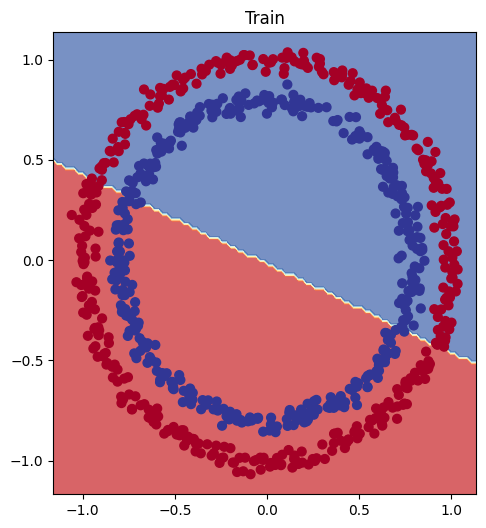

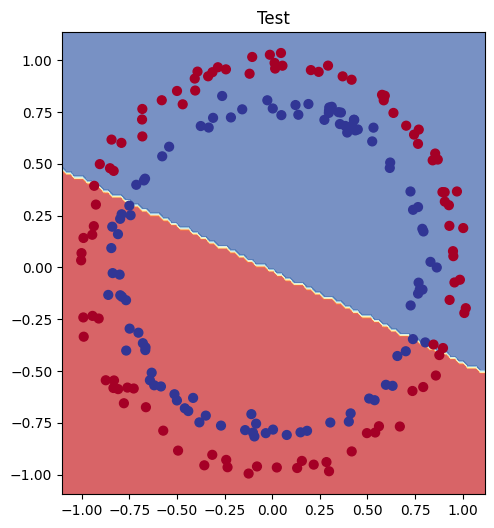

In [18]:
# Upravte si parametry ať sedí do vašeho kódu

plt.figure(figsize = (12,6)) # nastavíme velikost zobrazení
plt.subplot(1,2,1) # Určíme počet x axis a y axis
plt.title("Train") # Title

plot_decision_boundary(model_0, x_train, y_train) # použijeme funkci kterou jsme si stáhli a ta nám vykreslí plot s ukázkou moderého pole pro 0 a pro 1 červené pole

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test) # Upravte si parametry ať sedí do vašeho kódu